Training the unet, first finetuning with the resnet frozen, then finetuning entire thing.

In [2]:
import unetModel

In [3]:
import generators

In [4]:
img_width = 768
img_height = 768
img_size = (img_height, img_width)
seed = 42
baseDir = '/home/ubuntu/notebooks/shipid/data/bigboats'
imgDir = os.path.join(baseDir, 'images')
maskDir = os.path.join(baseDir, 'masks')
batchSize = 3

In [19]:
#reload(create_unet)

<module 'create_unet' from '/home/gregw/code/Kaggle/ShipId/kerasUnet/create_unet.py'>

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, Input, concatenate
import numpy as np


In [6]:
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(768, 768, 3))


In [6]:
import keras
keras.__version__

'2.2.4'

In [8]:
#base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 774, 774, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 384, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 384, 384, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
reload(unetModel)
#myU = unetModel.getUnet()
myU = unetModel.getUnet('freeze1.h5')

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
myU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 774, 774, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 384, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 384, 384, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
#unetModel.lastResNetLayer

175

In [9]:
#myU.get_layer(index=174).name

'activation_49'

In [10]:
#len(myU.layers)

196

In [11]:
#myU.get_layer(index=195).name

'conv2d_11'

In [19]:
reload(generators)

<module 'generators' from '/home/ubuntu/notebooks/shipid/kerasUnet/generators.py'>

In [13]:
#img_size
#type(img_size)
#myT = tuple(img_size)
#print(myT, type(myT))
#print(imgDir, maskDir)

(768, 768) <class 'tuple'>
/home/ubuntu/notebooks/shipid/data/bigboats/images /home/ubuntu/notebooks/shipid/data/bigboats/masks


In [9]:
train_gen, valid_gen = generators.getTrainValidGenerators(imgDir, maskDir, 0.20, img_size, 3)

Found 136 images belonging to 1 classes.
Found 136 images belonging to 1 classes.
Found 34 images belonging to 1 classes.
Found 34 images belonging to 1 classes.


In [10]:
from keras.optimizers import *
myU.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_squared_error', metrics = ['accuracy'])


In [11]:
myU.fit_generator( 
            train_gen,
            steps_per_epoch = 2,
            validation_data = valid_gen,
            validation_steps = 6,
            epochs = 1
            )

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2/2 [==============================] - 53s 27s/step - loss: 0.0060 - acc: 0.9936 - val_loss: 0.0096 - val_acc: 0.9898


In [11]:
myU.fit_generator( 
            train_gen,
            steps_per_epoch = 26,
            validation_data = valid_gen,
            validation_steps = 6,
            epochs = 3
            )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
26/26 [==============================] - 134s 5s/step - loss: 0.0268 - acc: 0.9686 - val_loss: 0.0093 - val_acc: 0.9901
Epoch 2/3
26/26 [==============================] - 113s 4s/step - loss: 0.0110 - acc: 0.9883 - val_loss: 0.0102 - val_acc: 0.9892
Epoch 3/3
26/26 [==============================] - 97s 4s/step - loss: 0.0084 - acc: 0.9910 - val_loss: 0.0090 - val_acc: 0.9904


In [12]:
myU.save('freeze1.h5')

In [12]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


In [13]:
test_dir = '/home/ubuntu/notebooks/shipid/data/bigboats/test'
test_datagen = ImageDataGenerator()

In [14]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(768,768), batch_size=3, class_mode=None)

Found 10 images belonging to 1 classes.


In [15]:
y_pred = myU.predict_generator(test_generator, verbose=1, steps=3)

3/3 [==============================] - 6s 2s/step


In [17]:
import matplotlib.image as mpimg
import numpy as np

In [62]:
y_pred.shape

(9, 768, 768, 1)

In [37]:
newd = np.reshape(y_pred[0],(768, 768))

In [38]:
newd.ndim

2

In [58]:
mpimg.imsave('mask_1.png', newd*255, cmap='gray')

In [23]:
import matplotlib.pyplot as plt

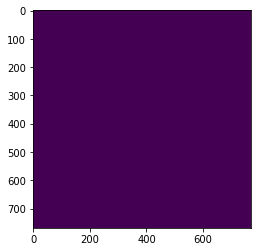

In [59]:
plt.imshow(newd)
plt.show()

In [61]:
i = 0
for img in y_pred:
    newd = np.reshape(img, (768, 768)) * 255
    fname = 'mask_' + str(i) + '.png'
    mpimg.imsave(fname, newd, cmap='gray')
    i = i + 1

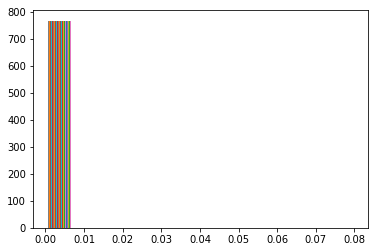

In [73]:
#hist = np.histogram(y_pred[0])
plt.hist(np.reshape(y_pred[1]*1000, (768, 768)), bins='auto')
#plt.hist(np.reshape(y_pred[0]*100000, (768, 768)), bins=[0.00000001, 0.0000001, 0.000001, 0.0001, 1])
plt.show()


In [95]:
test_generator.filenames

['boats/0027854cc.jpg',
 'boats/002d56570.jpg',
 'boats/0040cf4e9.jpg',
 'boats/009751652.jpg',
 'boats/00d0a646b.jpg',
 'boats/00fd8e126.jpg',
 'boats/0106d2433.jpg',
 'boats/014624873.jpg',
 'boats/014c906b1.jpg',
 'boats/016017695.jpg']

In [96]:
test_generator.index_array

array([4, 2, 3, 9, 7, 6, 5, 0, 1, 8])

In [97]:
fn = test_generator.filenames[2]
base, ext = os.path.splitext(fn)
fn = base + ".png"
print(fn)

boats/0040cf4e9.png


In [19]:
mask_dir = '/home/ubuntu/notebooks/shipid/data/bigboats/masks'
mk = mpimg.imread(os.path.join(mask_dir,fn))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/notebooks/shipid/data/bigboats/masks/boats/016017695.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


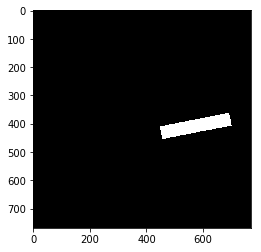

In [101]:
plt.imshow(mk*255)
plt.show()

In [100]:
np.amax(mk)

1.0

In [104]:
mk.shape[1]

768

In [108]:
mk.shape
mk[0,0,0]

0.0

In [42]:
i = 0
for fileIdx in test_generator.index_array:
    pred_mask = y_pred[i]
    
    # Get name of target mask, read it in.
    fn = test_generator.filenames[fileIdx]
    base, ext = os.path.splitext(fn)
    filename = base + ".png"
    mask = mpimg.imread(os.path.join(mask_dir,filename))

    # See if nonzero pixels in target mask and predicted mask match, same with zeros.
    hits = 0
    misses = 0
    targetOnes = 0
    predOnes = 0
    for row in range(0, mask.shape[0]-1):
        for col in range(0, mask.shape[1]-1):
            if mask[row, col, 0] > 0 and pred_mask[row, col, 0] > 0:
                hits += 1
            elif mask[row, col, 0] == 0 and pred_mask[row, col, 0] == 0:
                hits += 1
            else:
                misses += 1
            if mask[row, col, 0] > 0:
                targetOnes += 1
            if pred_mask[row, col, 0] > 0:
                predOnes += 1
    print( "for image: ", filename, " had ", hits, " hits and ", misses, " misses, target ones=", targetOnes,
          ", predicted ones=", predOnes)
    i += 1


for image:  boats/016017695.png  had  583575  hits and  4714  misses, target ones= 4714 , predicted ones= 0
for image:  boats/00d0a646b.png  had  577445  hits and  10844  misses, target ones= 10844 , predicted ones= 0
for image:  boats/0027854cc.png  had  586534  hits and  1755  misses, target ones= 1754 , predicted ones= 1
for image:  boats/0106d2433.png  had  585227  hits and  3062  misses, target ones= 3061 , predicted ones= 1
for image:  boats/014c906b1.png  had  583591  hits and  4698  misses, target ones= 4697 , predicted ones= 1
for image:  boats/014624873.png  had  577715  hits and  10574  misses, target ones= 10573 , predicted ones= 1
for image:  boats/0040cf4e9.png  had  576878  hits and  11411  misses, target ones= 11410 , predicted ones= 1
for image:  boats/00fd8e126.png  had  577650  hits and  10639  misses, target ones= 10639 , predicted ones= 0
for image:  boats/002d56570.png  had  586996  hits and  1293  misses, target ones= 1292 , predicted ones= 1


IndexError: index 9 is out of bounds for axis 0 with size 9

In [38]:
pred1 = y_pred[0,:,:,0]
print(np.amax(pred1))
scalefactor = 255/np.amax(pred1)
scalepred1 = pred1 * scalefactor
print(np.amax(scalepred1))

4.4703484e-07
255.0


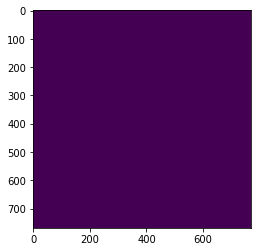

In [39]:
plt.imshow(scalepred1)

In [32]:
np.amax(pred1)
pred1.shape

(768, 768)

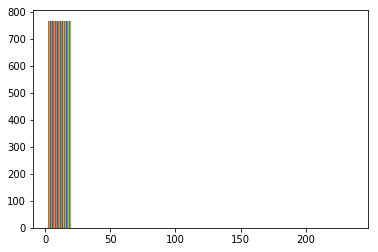

In [33]:
plt.hist(pred1, bins='auto')
#plt.hist(np.reshape(y_pred[0]*100000, (768, 768)), bins=[0.00000001, 0.0000001, 0.000001, 0.0001, 1])
plt.show()